In [1]:
!pip install opencv-python

In [76]:
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

import warnings

# Set the desired warning filter level
warnings.filterwarnings("ignore")

In [3]:
#Train data
train_data_dir = Path("Dataset_Detection_of_Lung_Infection/data/train")

#Test data
test_data_dir = Path("Dataset_Detection_of_Lung_Infection/data/test")

## 1.2. Plot the sample images for all the classes:

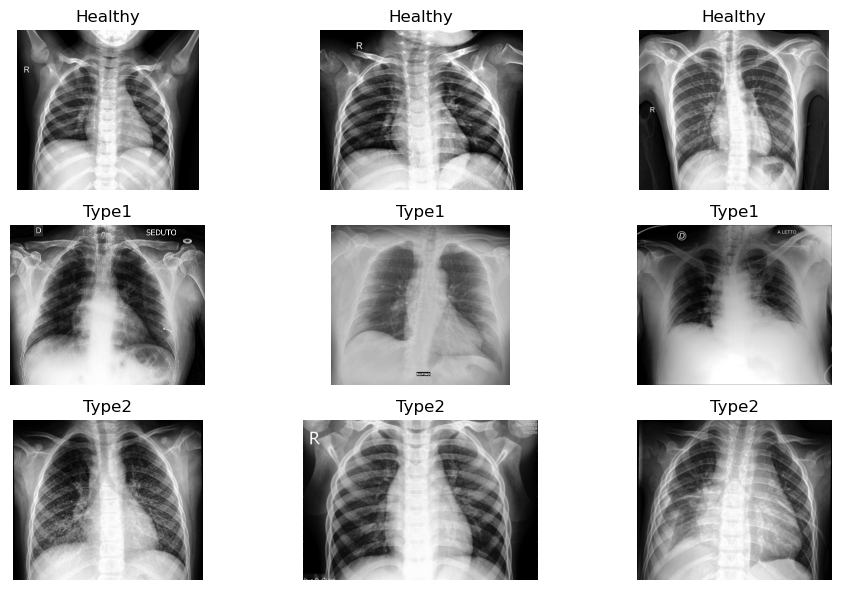

In [4]:
class_names = os.listdir(train_data_dir)
num_classes = len(class_names)

fig, axes = plt.subplots(nrows=num_classes, ncols=3, figsize=(10, 2*num_classes))

for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_data_dir, class_name)
    image_files = os.listdir(class_path)[:3]  # Select first 5 images
    
    for j, image_file in enumerate(image_files):
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i, j].imshow(image)
        axes[i, j].axis('off')
        axes[i, j].set_title(class_name)
        
plt.tight_layout()
plt.show()

## 1.3. Plot the distribution of images across the classes

In [5]:
#Write files named to the list per class:

healthy = list(train_data_dir.glob("Healthy/*"))
type1 = list(train_data_dir.glob("Type1/*"))
type2 = list(train_data_dir.glob("Type2/*"))

In [6]:
#Count number of images in the directories:
num_healthy = len(healthy)
num_type1 = len(type1)
num_typ2 = len(type2)

print("Healthy: ", num_healthy)
print("Type 1: ", num_type1)
print("Type 2: ", num_typ2)

Healthy:  70
Type 1:  111
Type 2:  70


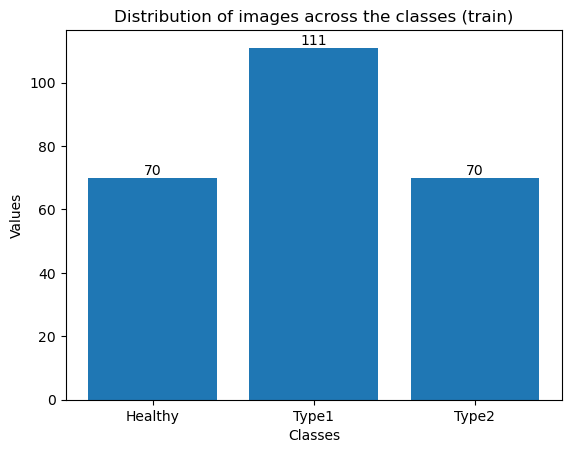

In [7]:
x = [len(healthy), len(type1), len(type2)]
y = ['Healthy', 'Type1', 'Type2']

plt.bar(y, x)
plt.xlabel('Classes')
plt.ylabel('Values')
plt.title('Distribution of images across the classes (train)')

for i in range(len(x)):
    plt.text(i, x[i], str(x[i]), ha='center', va='bottom')

plt.show()

## 1.4. Build a data augmentation for train data to create new data with translation, rescale and flip, and rotation transformations. Rescale the image at 48x48

(1) Translation Or Shift:

- width_shift_range -  parameter controls the range (as a fraction of total width or height) for randomly shifting the images horizontally
- height_shift_range - parameters control the range (as a fraction of total width or height) for randomly shifting the images vertically

(2) Rescale: 

- rescale=1./255 - scales the pixel values of the images by dividing them by 255.
- This operation normalizes the pixel values between 0 and 1, which is a common practice for preprocessing images.

(3) Flip:

- horizontal_flip=True - randomly flips the images horizontally. 
- This transformation can help invariance to horizontal reflections and increase the robustness of the model.

(4) Rotation:

- rotation_range=60 - specifies the range (in degrees) for randomly rotating the images. 

(5) Zooming:

- zoom_range=0.25
- it helps the model learn to recognize objects at different scales. 

In [20]:
train_data_generator = []
test_data_generator = []

In [21]:
#Image size
batch_size = 32
img_height = 48
img_width = 48

In [22]:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True
)

train_generator = train_data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_height,img_width),  #to be sure that all images are re-sized to 48x48 before the training
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

Found 251 images belonging to 3 classes.


Note: **shuffle=True** ensures that the training data is randomly shuffled during each epoch. This randomization helps in reducing potential biases and ensures that the model sees a diverse set of samples in each training iteration. Shuffling the training data also prevents the model from memorizing the order of the samples, promoting better generalization to unseen data.

In [15]:
train_generator

## 1.5. Build a data augmentation for test data to create new data and rescale the image at 48x48

In [23]:
test_data_generator = ImageDataGenerator(rescale=1./255)

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_height,img_width),  #to be sure that all images are re-sized to 48x48 before the training
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 61 images belonging to 3 classes.


Note: **shuffle=False** in the test_generator ensures that the order of test samples remains unchanged, allowing for consistent evaluation and comparison of the model's predictions with truth labels.

# 2.1. Model-1. 

CNN Architecture:

- Add convolutional layers with different filters, max pool layers, dropout layers, and batch normalization layers  
- Use Relu as an activation function
- Take the loss function as categorical cross-entropy
- Take rmsprop as an optimizer
- Use early stopping with the patience of two epochs and monitor the validation loss or accuracy
- Try with ten numbers epoch
- Train the model using a generator and test the accuracy of the test data at every epoch
- Plot the training and validation accuracy, and the loss
- Observe the precision, recall the F1-score for all classes for both grayscale and color models, and determine if the model’s classes are good




In [26]:
# Delete the model if any excist
del model

In [27]:
# Build the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

Epoch 1/10
8/8 [==============================] - 9s 1s/step - loss: 1.2408 - accuracy: 0.4542 - val_loss: 1.2190 - val_accuracy: 0.3443
Epoch 2/10
8/8 [==============================] - 6s 810ms/step - loss: 0.9445 - accuracy: 0.6096 - val_loss: 1.2630 - val_accuracy: 0.3443
Epoch 3/10
8/8 [==============================] - 6s 800ms/step - loss: 0.7930 - accuracy: 0.6813 - val_loss: 1.2313 - val_accuracy: 0.1803


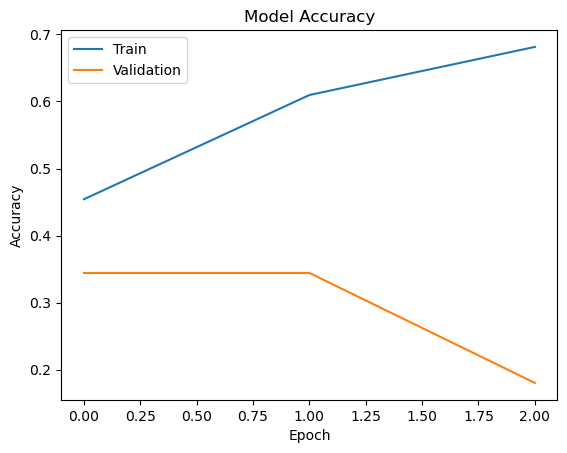

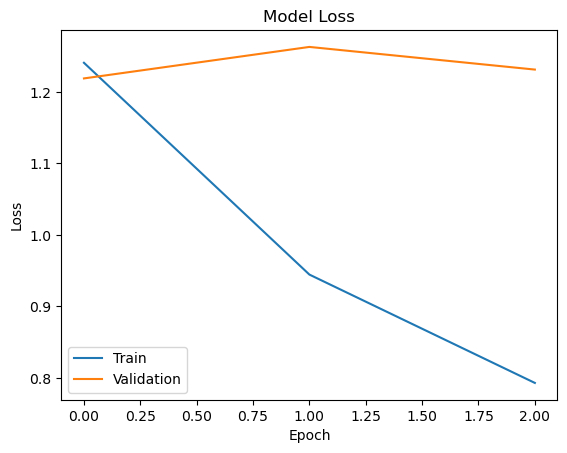

2/2 [==============================] - 1s 523ms/step - loss: 1.2313 - accuracy: 0.1803
Test Loss: 1.2313342094421387
Test Accuracy: 0.1803278625011444


In [28]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Early stopping
early_stopping = EarlyStopping(patience=2, monitor='val_loss', mode='min')

# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator,
    callbacks=[early_stopping]
)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


In [29]:
# Predict the classes for test data
test_predictions = model.predict(test_generator)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Get true test classes
test_true_classes = test_generator.classes

# Generate classification report
class_names = list(test_generator.class_indices.keys())
classification_rep = classification_report(test_true_classes, test_pred_classes, target_names=class_names)
print("Classification Report:")
print(classification_rep)

2/2 [==============================] - 1s 500ms/step
Classification Report:
              precision    recall  f1-score   support

       Type1       0.22      0.52      0.31        21
       Type2       0.00      0.00      0.00        20
     healthy       0.00      0.00      0.00        20

    accuracy                           0.18        61
   macro avg       0.07      0.17      0.10        61
weighted avg       0.07      0.18      0.11        61



### Conclution for Model-1:
Based on the provided test results, the model does not perform well. The accuracy is only around 18%, indicating that the model is not able to correctly classify the images. The precision, recall, and F1-score for most classes are low or zero, suggesting that the model is not effectively distinguishing between different classes. The overall performance is poor, and improvements are needed to make the model more accurate and reliable.

# 2.2. Model-2.

Transfer learning using mobile net:
    
- Prepare data for the pre-trained mobile net model, with color mode as RGB
- Create an instance of a mobile net pre-trained model 
- Add dense layer, dropout layer, batch normalization layer on the pre-trained model
- Create a final output layer with a SoftMax activation function
- Change the batch size activation function and optimize as rmsprop and observe if the accuracy increases
- Take the loss function as categorical cross-entropy
- Use early stopping with the patience of two epoch and call back function for preventing overfitting
- Try with ten numbers epoch
- Train the model using a generator and test the accuracy of the test data at every epoch
- Plot the training and validation accuracy, and the loss
- Observe the precision, recall the F1-score for all classes for both grayscale and color models, and determine if the model’s classes are good

In [56]:
del model_2

Found 251 images belonging to 3 classes.
Found 61 images belonging to 3 classes.
Epoch 1/10
8/8 [==============================] - 20s 2s/step - loss: 0.7840 - accuracy: 0.7331 - val_loss: 8.5193 - val_accuracy: 0.0492
Epoch 2/10
8/8 [==============================] - 15s 2s/step - loss: 0.4616 - accuracy: 0.8486 - val_loss: 5.5035 - val_accuracy: 0.0820
Epoch 3/10
8/8 [==============================] - 15s 2s/step - loss: 0.4231 - accuracy: 0.8406 - val_loss: 4.8104 - val_accuracy: 0.1639
Epoch 4/10
8/8 [==============================] - 15s 2s/step - loss: 0.1215 - accuracy: 0.9602 - val_loss: 5.5780 - val_accuracy: 0.1803
Epoch 5/10
8/8 [==============================] - 16s 2s/step - loss: 0.3690 - accuracy: 0.8845 - val_loss: 6.1677 - val_accuracy: 0.0984


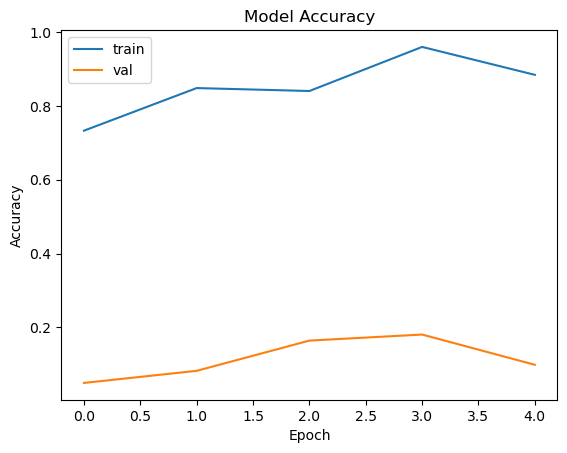

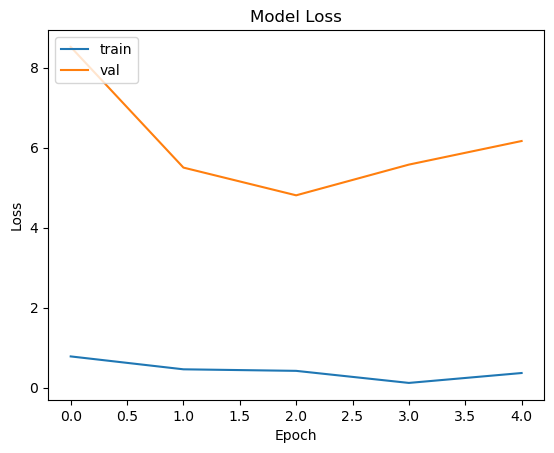

2/2 [==============================] - 1s 625ms/step - loss: 4.8104 - accuracy: 0.1639
Test Loss: 4.81036376953125
Test Accuracy: 0.16393442451953888


In [57]:
# Image size:
batch_size = 32
img_height = 224
img_width = 224

# Train data preprocessing:
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True
)

train_generator = train_data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

# Test data pre-processing:
test_data_generator = ImageDataGenerator(rescale=1./255)

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Create an instance of a pre-trained MobileNet model
base_model = MobileNet(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Model
model_2 = Sequential()
model_2.add(base_model)
model_2.add(GlobalAveragePooling2D())  # to reduce the dimensions, otherwise will have an error
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.2))
model_2.add(BatchNormalization())
model_2.add(Dense(num_classes, activation='softmax'))

# Compiling
model_2.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

# Use early stopping with a patience of two epochs
early_stopping = EarlyStopping(patience=2, monitor='val_loss', restore_best_weights=True)

# Train the model using a generator and test the accuracy of the test data at every epoch
history = model_2.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping]
)

# Plot the training and validation accuracy, and the loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluate the model on the test data
test_loss, test_accuracy = model_2.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


In [63]:
# Predict the classes for test data
test_predictions = model_2.predict(test_generator)
test_pred_classes = np.argmax(test_predictions, axis=1)

# Get true test classes
test_true_classes = test_generator.classes

# Generate classification report
class_names = list(test_generator.class_indices.keys())
classification_rep = classification_report(test_true_classes, test_pred_classes, target_names=class_names)
print("Classification Report:")
print(classification_rep)

2/2 [==============================] - 1s 610ms/step
Classification Report:
              precision    recall  f1-score   support

       Type1       0.00      0.00      0.00        21
       Type2       0.00      0.00      0.00        20
     healthy       0.32      0.50      0.39        20

    accuracy                           0.16        61
   macro avg       0.11      0.17      0.13        61
weighted avg       0.11      0.16      0.13        61



### Conclutions Model-2:

The overall accuracy of the model is 0.33, which means it correctly predicts the class for approximately 16% of the samples.
The macro average F1-score, which gives equal weight to each class, is 0.17. The weighted average F1-score, which considers class imbalance, is also 0.17.
Based on these results, the model's performance is poor. It fails to predict Type1 and Type2 classes, while it performs relatively better for the healthy class. Further improvements are necessary to enhance the model's accuracy and F1-scores for all classes.

# 2.3. Model-3

Transfer Learning using Densenet121:
    
- Prepare the dataset for the transfer learning algorithm using Densenet121 with the image size as 224x224x3
- Freeze the top layers of the pre-trained model
- Add a dense layer at the end of the pre-trained model followed by a dropout layer and try various combinations to get an accuracy
- Add the final output layer with a SoftMax activation function
- Take loss function as categorical cross-entropy
- Take Adam as an optimizer
- Use early stopping to prevent overfitting
- Try with 15 number of epoch and batch size with seven, also try various values to see the impact on results
- Train the model using the generator and test the accuracy of the test data at every epoch 
- Plot the training and validation accuracy, and the loss
- Observe the precision, recall the F1-score for all classes for both grayscale and color models, and determine if the model’s classes are good

In [71]:
del model

Found 251 images belonging to 3 classes.
Found 61 images belonging to 3 classes.
Epoch 1/15
36/36 [==============================] - 30s 725ms/step - loss: 0.8418 - accuracy: 0.6733 - val_loss: 2.8782 - val_accuracy: 0.0328
Epoch 2/15
36/36 [==============================] - 26s 716ms/step - loss: 0.4865 - accuracy: 0.7928 - val_loss: 2.8246 - val_accuracy: 0.1148
Epoch 3/15
36/36 [==============================] - 26s 709ms/step - loss: 0.4567 - accuracy: 0.8207 - val_loss: 3.1139 - val_accuracy: 0.0328
Epoch 4/15
36/36 [==============================] - 26s 723ms/step - loss: 0.4006 - accuracy: 0.8566 - val_loss: 3.2654 - val_accuracy: 0.0492


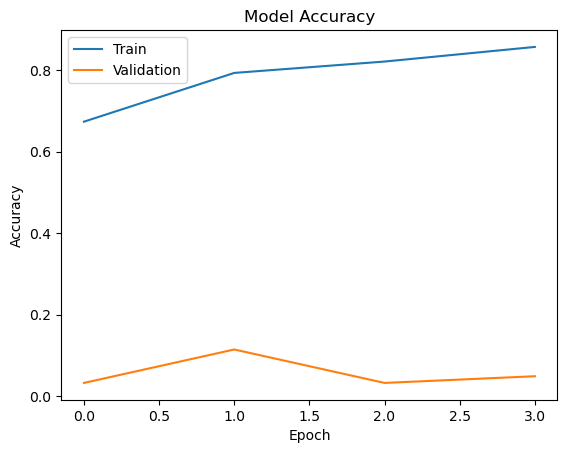

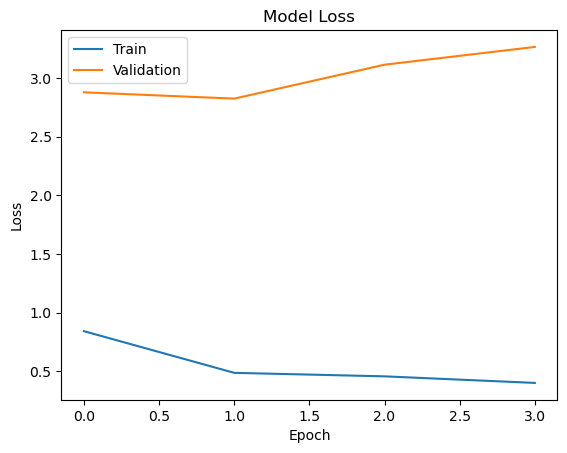

9/9 [==============================] - 5s 573ms/step - loss: 2.8246 - accuracy: 0.1148
Test Loss: 2.8245785236358643
Test Accuracy: 0.1147540956735611


In [66]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Set the parameters
img_height = 224
img_width = 224
num_classes = 3  # Update with the actual number of classes in your dataset
batch_size = 7
num_epochs = 15

# Prepare the dataset
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True
)

train_generator = train_data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

test_data_generator = ImageDataGenerator(rescale=1./255)

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Create the DenseNet121 model with pre-trained weights
base_model = DenseNet121(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze the top layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the pre-trained model
# Model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())  # Add this line to reduce the dimensions)
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=2, monitor='val_loss', restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

# Plot the training and validation accuracy, and the loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


In [68]:
from sklearn.metrics import classification_report

# Compute precision, recall, and F1-score for all classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
class_labels = list(test_generator.class_indices.keys())

classification_rep = classification_report(test_generator.classes, y_pred_classes, target_names=class_labels)
print("Classification Report:")
print(classification_rep)

9/9 [==============================] - 6s 616ms/step
Classification Report:
              precision    recall  f1-score   support

       Type1       0.00      0.00      0.00        21
       Type2       0.00      0.00      0.00        20
     healthy       0.28      0.35      0.31        20

    accuracy                           0.11        61
   macro avg       0.09      0.12      0.10        61
weighted avg       0.09      0.11      0.10        61



Found 251 images belonging to 3 classes.
Found 61 images belonging to 3 classes.
Epoch 1/15
4/4 [==============================] - 25s 6s/step - loss: 1.0321 - accuracy: 0.5498 - val_loss: 2.5649 - val_accuracy: 0.2131
Epoch 2/15
4/4 [==============================] - 20s 5s/step - loss: 0.4926 - accuracy: 0.7928 - val_loss: 3.3277 - val_accuracy: 0.1967
Epoch 3/15
4/4 [==============================] - 19s 5s/step - loss: 0.4019 - accuracy: 0.8446 - val_loss: 3.6120 - val_accuracy: 0.1475


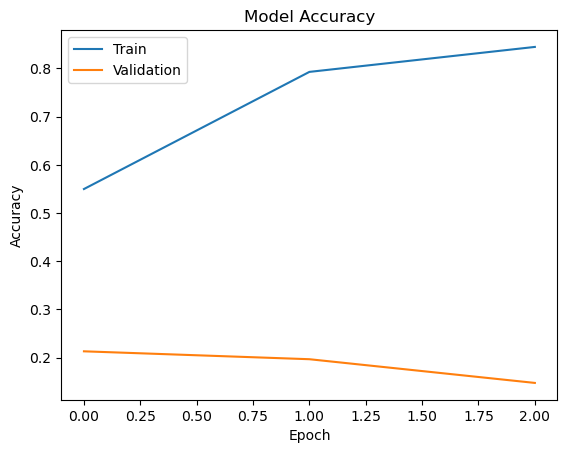

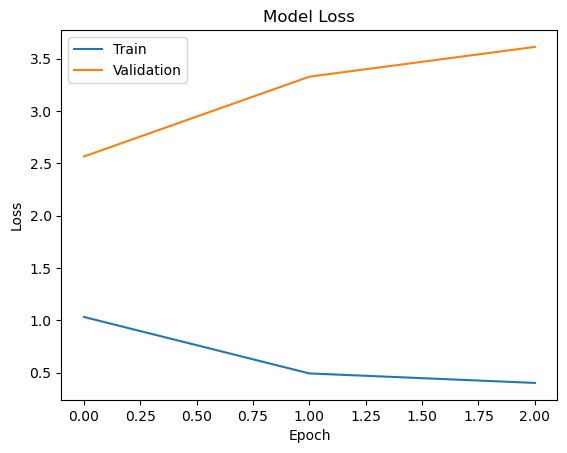

1/1 [==============================] - 4s 4s/step - loss: 2.5649 - accuracy: 0.2131
Test Loss: 2.5649304389953613
Test Accuracy: 0.21311475336551666


In [72]:
#Batch = 64

# Set the parameters
img_height = 224
img_width = 224
num_classes = 3  # Update with the actual number of classes in your dataset
batch_size = 64
num_epochs = 15

# Prepare the dataset
train_data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True
)

train_generator = train_data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

test_data_generator = ImageDataGenerator(rescale=1./255)

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

# Create the DenseNet121 model with pre-trained weights
base_model = DenseNet121(input_shape=(img_height, img_width, 3), include_top=False, weights='imagenet')

# Freeze the top layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the pre-trained model
# Model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())  # Add this line to reduce the dimensions)
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Use early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=2, monitor='val_loss',mode='min', restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[early_stopping]
)

# Plot the training and validation accuracy, and the loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


In [73]:
# Compute precision, recall, and F1-score for all classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
class_labels = list(test_generator.class_indices.keys())

classification_rep = classification_report(test_generator.classes, y_pred_classes, target_names=class_labels)
print("Classification Report:")
print(classification_rep)

1/1 [==============================] - 5s 5s/step
Classification Report:
              precision    recall  f1-score   support

       Type1       0.27      0.48      0.34        21
       Type2       0.00      0.00      0.00        20
     healthy       0.16      0.15      0.15        20

    accuracy                           0.21        61
   macro avg       0.14      0.21      0.17        61
weighted avg       0.14      0.21      0.17        61



# 3. Comparison analysis:

Based on these results, it appears that Model4 performs relatively better compared to the other models. It has higher precision and recall values for Type1, indicating a better ability to classify instances of Type1. However, overall performance for all models is generally low, with low accuracy and f1-scores across the board. 

Further analysis and improvements may be necessary to enhance the classification performance.